# Binomial Model Pricing

**L'objectif est de partir du modèle binomial, le faire de manière à ce qu'il soit modifiable, les paramètres doivent être modifiables pour tester et voir les différences par exemple entre l'environnement réel ou sans risque, il faut aller jusqu'au bout de ce qui a été montré dans les deux premiers chapitres de Stochastic Calculus for Finance vol i. Donc non seulement faire la modélisation du prix Sn mais aussi du portefeuille Xn ainsi que du produit dérivé Vn. Il faut faire une stratégie de portefeuille qui prend en compte de la dette et des rendements liés au marché monétaire avec les taux d'intérêts. Pour appliquer certaines propriétés vérifier si le processus qui est créé est Markovien, ou une Martingale en fonction de ces résultats on verra si les données utilisées sont necessaires pour estimer le prix du sous jacent ou du produit dérivé car cela montrera si le processus est Path-dependant ou non et dans le cas où c'est une martingale cela indiquera que le processus n'a pas de tendence à augmenter ou baisser. Si possible Aller jusqu'à l'application de la démonstration de Black & Scholes en faisant évoluer le modèle binomial vers une lognormalité en faisant tendre ∆t vers 0 avec n qui tend vers l'infini.**

### 1.Modèle Binomial Multi-périodes
Hypothèses :
- Absence d'abitrage => $0<d<e^{r∆t}<u \cdot$
- Constant taux d'intérêt r

### Formule Générale
- Prix initial du sous jacent $S_0>0 \cdot $
- mouvement up : $u $ =$e^{\sigma*\sqrt{∆t}} $
- mouvement down : $d$ =$e^{-\sigma*\sqrt{∆t}}$
- sigma = 0.15
- probabilité : Réelle ou risque neutre =>
- $ p^~= \frac{e^{r*∆t}-d}{u-d} \cdot$
- $ q^~ = 1-p^~$
- k = Nombre de hausses
- n = nombre de périodes
> $$ S_{n,k}=S_0*u^k*d^{n-k} $$

In [3]:
import math
import numpy as np

In [146]:
# definition des variables
S0=50
sigma=0.15
T=1.0 #durée en année
r=0.05

In [113]:
#fonction de simulation de l'arbre binomial
def simulate_tree(n):
    delta_t= T/n
    u =math.exp(sigma*math.sqrt(delta_t))
    d=1/u
    Sn= np.zeros((n+1, n+1))
    Sn[0,0] = S0
    z=1 #compteur interne pour que la boucle aille jusqu'à t
    for t in range(1, n+1): # t période du modèle binomial
        for k in range(z):
            Sn[k,t]=Sn[k, t-1]*u
            Sn[k+1, t] = Sn[k, t-1]*d
        z+=1
    return Sn, u, d, delta_t

In [21]:
#limitation de l'affichage des valeurs
np.set_printoptions(formatter={'float':lambda x: '%6.2f' % x})

In [83]:
#affichage de la matrice np.zeros qui enregistre les valeurs de Sn
simulate_tree(5)

(array([[ 50.00,  53.47,  57.18,  61.15,  65.39,  69.93],
        [  0.00,  46.76,  50.00,  53.47,  57.18,  61.15],
        [  0.00,   0.00,  43.72,  46.76,  50.00,  53.47],
        [  0.00,   0.00,   0.00,  40.89,  43.72,  46.76],
        [  0.00,   0.00,   0.00,   0.00,  38.23,  40.89],
        [  0.00,   0.00,   0.00,   0.00,   0.00,  35.75]]),
 1.0693832060523671,
 0.9351184817007782,
 0.2,
 4)

## Maintenant que le processus de prix Sn est fait, je veux vérifier qu'il est bien une Variable Aléatoire

**Pour cela il faut dans un premier temps vérifier sa distribution discrète via le log de Sn**
**Puis Faire tendre n vers l'infini afin de voir la distribution se lisser**

**Ensuite on peut passer à la vérification que le processus Sn est Markovien ou Martingale**

In [98]:
import matplotlib.pyplot as plt
from scipy.stats import binom
from math import comb

In [114]:
def test_arbitrage_conditions(n):
    #vérification de la condition d'absence d'arbitrage
    no_arbitrage=0
    Sn, u, d, delta_t=simulate_tree(n)    
    
    if 0 < d < math.exp(r*delta_t) < u:
        no_arbitrage = 1
    else:
        no_arbitrage = 0
    return no_arbitrage

In [215]:
def multiperiod_binomial_model_analysis(n, plot=True):
    no_arbitrage = test_arbitrage_conditions(n)
    if no_arbitrage == 0:
        print("Condition de non arbitrage non respectée")
        return None
    
    # Calcul des probabilités pour chaque valeur finale de l'arbre
    Sn, u, d, delta_t = simulate_tree(n)
    p = (math.exp(r*delta_t) - d) / (u - d)
    q = 1 - p
    
    probabilities = []
    for j in range(n+1):
        # j nombre de mouvements up
        num_ups = j
        num_downs = n - j
        path_prob = math.comb(n, j) * (p**num_ups) * (q**num_downs)
        probabilities.append(path_prob)  # DÉPLACÉ À L'INTÉRIEUR DE LA BOUCLE
    
    final_prices = Sn[:n+1, n]

    if plot : 
        # Histogramme de S_n
        plt.figure(figsize=(12,6))
        plt.hist(final_prices, bins=30, weights=probabilities, density=True, 
                 alpha=0.7, label='Distribution empirique')
        
        # Courbe Lognormale Théorique
        mu = (r - 0.5 * sigma**2) * T
        s = sigma * np.sqrt(T)
        
        # Paramètres pour Scipy Lognormal
        shape = s
        scale = S0 * np.exp(mu)  # Corrigé : devrait être exp(mu) pas exp(r*T)
        
        x = np.linspace(min(final_prices) * 0.8, max(final_prices) * 1.2, 1000)
        pdf_lognormal = lognorm.pdf(x, s=shape, scale=scale)
        
        plt.plot(x, pdf_lognormal, 'r-', linewidth=2, 
                 label='Distribution lognormale théorique')
        
        plt.title(f"Distribution empirique pondérée de S_{n} vs. Distribution lognormale")
        plt.xlabel("Prix final")
        plt.ylabel("Densité")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Histogramme de log(S_n)
        plt.figure(figsize=(12,6))
        
        log_prices = np.log(final_prices)
        hist_values, bin_edges, _ = plt.hist(log_prices, bins=min(50, n+1), weights=probabilities, density=True, alpha=0.7,label='Distribution empirique de log(S_n)') 
                                             
                                             
        # Courbe Normale Théorique
        mu_log = np.log(S0) + (r - 0.5 * sigma**2) * T
        std = sigma * np.sqrt(T)
        
        x = np.linspace(min(log_prices) - 0.5*std, max(log_prices) + 0.5*std, 1000)
        plt.plot(x, norm.pdf(x, mu_log, std), 'r-', linewidth=2, 
                 label='Distribution normale théorique')
        
        # KL divergence sert à vérifier la convergence entre la courbe théorique et mon résultat
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        theoretical_values = norm.pdf(bin_centers, mu_log, std)
        
        if np.all(hist_values > 0) and np.all(theoretical_values > 0):
            kl_div = np.sum(hist_values * np.log(hist_values / theoretical_values))
            plt.text(0.05, 0.95, f"KL Divergence: {kl_div:.6f}", 
                     transform=plt.gca().transAxes, fontsize=10,
                     verticalalignment='top', 
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        plt.title(f"Distribution empirique de log(S_{n}) vs. Distribution normale")
        plt.xlabel("log(S_n)")
        plt.ylabel("Densité")
        plt.legend()
        plt.grid(True)
        
        info_text = (f"Paramètres: S0={S0}, r={r}, σ={sigma}, T={T}, n={n}\n"
                     f"μ={mu_log:.4f}, σ={std:.4f}")
        plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=10, 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
    
    return Sn, p, q, delta_t

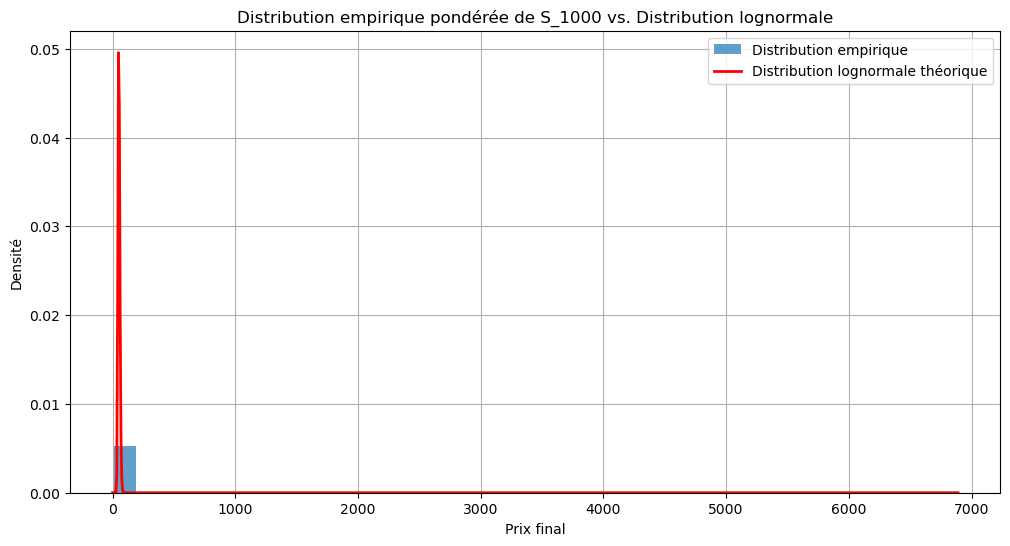

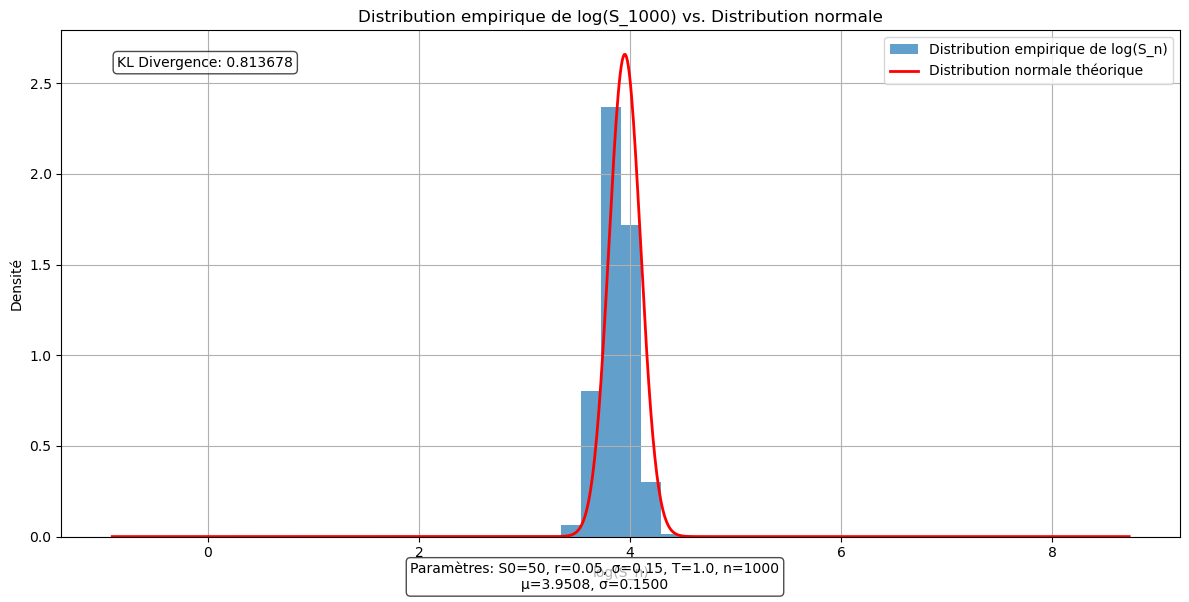

(array([[ 50.00,  50.24,  50.48, ..., 5687.08, 5714.12, 5741.29],
        [  0.00,  49.76,  50.00, ..., 5633.39, 5660.17, 5687.08],
        [  0.00,   0.00,  49.53, ..., 5580.19, 5606.73, 5633.39],
        ...,
        [  0.00,   0.00,   0.00, ...,   0.44,   0.44,   0.44],
        [  0.00,   0.00,   0.00, ...,   0.00,   0.44,   0.44],
        [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.44]]),
 0.504084722866947,
 0.49591527713305295,
 0.001)

In [216]:
multiperiod_binomial_model_analysis(1000,True)

### J'ai donc un processus stochastique Sn bien défini : 
- Conditions de non-arbitrage vérifiées
- Convergence vers lognormale démontrable en faisant tendre n vers l'infini
- Convergence Visible avec KL lorsque n tends vers des grand nombres on voit la variable KL qui diminue et se rapproche de plus en plus de 0
> Sn est donc une Variable Aléatoire représentant le processus stochastique de l'évolution du prix du sous jacent sous probabilités risque neutres.

**Je peux donc passer à la suite pour l'évaluation que ce processus est Markovien ou Martingale**
Je commence par regarder si la variable aléatoire Sn rempli les conditions pour être une Martingale : 

- Le processus Sn doit être une séquence de Variables Aléatoires
- Chaque valeur de la variable Aléatoire doit dépendre uniquement des premiers lancés n et M_0 constant
- Cette séquence de variables aléatoires doit être un processus stochastic adapté.

Ce qui signifie qu'une martingale doit respecter la condition suivante : 
$$S_n=\mathbb{E}{[S_{n+1}]} $$

In [194]:
def verification_martingale(n):
    # Récupération des variables
    Sn, p, q, delta_t= multiperiod_binomial_model_analysis(n,False)
    e = 0.0000001  # Marge d'erreur
    
    for t in range(n):  # Pour chaque étape t (de 0 à n-1)
        for k in range(t + 1):  # Pour chaque nœud à l'étape t
            # Valeur actuelle du processus
            S_curr = Sn[k, t]
            
            # Valeurs possibles à l'étape suivante
            S_up = Sn[k, t + 1]
            S_down = Sn[k + 1, t + 1]
            
            # Espérance conditionnelle actualisée du taux r continu sinon on a une submartingale
            expected = (p * S_up + q * S_down) * math.exp(-r * delta_t)
            
            # Comparaison avec la valeur actuelle
            if abs(expected - S_curr) > e:
                print(f"Échec au nœud (k={k}, t={t}): E[S_{{t+1}}|S_t] = {expected:.6f} ≠ S_t = {S_curr:.6f}")
                print("Sn n'est pas une Martingale")
                return False
    
    # Si on arrive ici, tous les nœuds vérifient la propriété
    print("Le processus actualisé est une Martingale")
    return True

In [195]:
verification_martingale(1000)

Le processus actualisé est une Martingale


True

### Montrons Maintenant par l'application du Lemme d'indépendance que Sn est Markovien

$$E[f(S_{n+1})|S_n, S_{n-1}]= E[f(S_{t+1}) | S_t]$$

In [212]:
def verification_markov(n):
    # verification que  : E[f(S_{n+1})|S_n, S_{n-1}]= E[f(S_{t+1}) | S_t]
    
    Sn, p, q, delta_t = multiperiod_binomial_model_analysis(n, False)
    u = math.exp(sigma*math.sqrt(delta_t))
    d = 1/u
    e = 0.0000001
    
    print("Vérification de la propriété de Markov :")
    print("-" * 70)
    print(f"Nombre de périodes : n = {n}")
    print(f"Vérification en cours...")
    print()
    
    total_comparisons = 0
    failures = 0
    
    for t in range(1, n):
        conditional_expectations = {}
        
        for k in range(t+1):
            S_curr = Sn[k, t]
            
            if k == 0:
                S_prev = Sn[0, t-1]
            elif k == t:
                S_prev = Sn[t-1, t-1]
            else:
                S_prev_from_up = Sn[k-1, t-1]
                S_prev_from_down = Sn[k, t-1]
                
                for S_prev, origin in [(S_prev_from_up, "up"), (S_prev_from_down, "down")]:
                    S_up = Sn[k, t + 1]
                    S_down = Sn[k + 1, t + 1]
                    expected = p * S_up + q * S_down
                    
                    if S_curr not in conditional_expectations:
                        conditional_expectations[S_curr] = []
                    conditional_expectations[S_curr].append((S_prev, expected, origin))
                continue
            
            # Pour les nœuds extrêmes (k=0 ou k=t)
            S_up = Sn[k, t + 1]
            S_down = Sn[k + 1, t + 1]
            expected = p * S_up + q * S_down
            
            if S_curr not in conditional_expectations:
                conditional_expectations[S_curr] = []
            conditional_expectations[S_curr].append((S_prev, expected, "unique"))
        
        # Vérifier la propriété de Markov
        for S_t, values in conditional_expectations.items():
            if len(values) > 1:
                total_comparisons += 1
                expectations = [v[1] for v in values]
                reference = expectations[0]
                all_equal = all(abs(exp - reference) < e for exp in expectations)
                
                # AFFICHER SEULEMENT LES ÉCHECS
                if not all_equal:
                    if failures == 0:
                        print("ÉCHECS DÉTECTÉS :")
                        print("-" * 70)
                    
                    failures += 1
                    print(f"\n✗ ÉCHEC #{failures} à l'étape t={t} pour S_t={S_t:.4f}:")
                    for S_prev, exp, origin in values:
                        print(f"    S_{{t-1}}={S_prev:.4f} ({origin:6s}) → E[S_{{t+1}}|S_t,S_{{t-1}}] = {exp:.4f}")
                    
                    # Limiter l'affichage à 10 échecs pour éviter la saturation
                    if failures >= 10:
                        print(f"\n... (Arrêt après 10 échecs affichés)")
                        print("\n" + "=" * 70)
                        print("✗ Le processus n'est PAS de Markov")
                        print(f"  {failures}+ échecs détectés sur {total_comparisons} comparaisons")
                        print("=" * 70)
                        return False
        
        # Afficher progression tous les 10% pour les grands n
        if n >= 100 and t % (n // 10) == 0:
            print(".", end="", flush=True)
    
    # Résultat final
    print("\n" + "=" * 70)
    if failures == 0:
        print("✓ Le processus vérifie la propriété de Markov")
        print(f"  {total_comparisons} comparaisons effectuées : TOUTES validées")
        print("  Pour chaque S_t, E[S_{t+1}|S_t] ne dépend pas de S_{t-1}")
    else:
        print("✗ Le processus n'est PAS de Markov")
        print(f"  {failures} échecs détectés sur {total_comparisons} comparaisons")
    print("=" * 70)
    
    return failures == 0

In [214]:
verification_markov(1000)

Vérification de la propriété de Markov :
----------------------------------------------------------------------
Nombre de périodes : n = 1000
Vérification en cours...

........
✓ Le processus vérifie la propriété de Markov
  498501 comparaisons effectuées : TOUTES validées
  Pour chaque S_t, E[S_{t+1}|S_t] ne dépend pas de S_{t-1}


True

### Le processus Stochastic Sn qui représente le prix d'une action ne payant pas de dividendes est donc bien une Variable Aléatoire, un processus de Markov lorsqu'il est actualisé et une Martingale, ce qui veut dire : 

- le modèle binomial n'autorise pas d'arbitrage
- tout payoff peut être répliqué par une stratégie auto-financante
- L'existence d'une martingale actualisée + complétude implique la construction d’une stratégie réplicante (delta hedging à chaque nœud)
- Comme Sn est un processus Markovien, alors les valeurs des dérivés et la stratégie réplicante à la date n ne dépendent que de la valeur actuelle Sn, pas de toute la trajectoire passée. Ainsi la valorisation se réduit à une récurrence (backward induction) sur les états Sn.
- Le fait que l’actif actualisé soit une martingale sous Q signifie économiquement que, sous la mesure appropriée, le prix actuel est la juste valeur (espérance actualisée) des prix futurs — il n’y a pas de prime d’espérance additionnelle en dehors du taux sans-risque.
- En faisant tendre le pas temporel vers 0 et en ajustant u,d, le modèle binomial converge (sous conditions) vers le modèle de Black–Scholes (mouvement brownien géométrique). Ton expérience numérique en Python peut donc servir de validation discrète du résultat continu.